In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, entropy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, LeakyReLU, BatchNormalization, Input
from stable_baselines3 import PPO
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from transformers import pipeline
import gymnasium as gym
from gymnasium import spaces
from collections import Counter
import requests

In [55]:
# --------------------------
# Fetch Stock Market Data
# --------------------------
stocks = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "META", "NFLX", "NVDA", "INTC", "ORCL",
          "IBM", "ADBE", "CRM", "CSCO", "QCOM", "TXN", "AVGO", "AMD", "SHOP", "UBER"]

combined = []
stock_data = {}
for stock in stocks:
    df = yf.download(stock, start="2020-01-01", end="2024-01-01")
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    df["Stock"] = stock
    df.index.name = "Date"
    combined.append(df)
    stock_data[stock] = df  # save individual for later use

full_df = pd.concat(combined).reset_index()
adj_close_data = full_df.pivot_table(index="Date", columns="Stock", values="Close").dropna(axis=1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [57]:
# --------------------------
# Linear Regression Model
# --------------------------

results = {}

for stock, df in stock_data.items():
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    X = scaled[:, [0, 1, 2, 4]]  # Open, High, Low, Volume
    y = scaled[:, 3]            # Close

    split_index = int(0.8 * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results[stock] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Print results
print("\n--- Linear Regression Results Per Stock ---")
for stock, metrics in results.items():
    print(f"{stock}: MSE={metrics['MSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")


--- Linear Regression Results Per Stock ---
AAPL: MSE=0.0000, MAE=0.0042, R²=0.9954
GOOGL: MSE=0.0001, MAE=0.0056, R²=0.9964
MSFT: MSE=0.0000, MAE=0.0048, R²=0.9970
AMZN: MSE=0.0001, MAE=0.0056, R²=0.9977
TSLA: MSE=0.0000, MAE=0.0049, R²=0.9955
META: MSE=0.0000, MAE=0.0055, R²=0.9977
NFLX: MSE=0.0000, MAE=0.0045, R²=0.9967
NVDA: MSE=0.0001, MAE=0.0061, R²=0.9980
INTC: MSE=0.0001, MAE=0.0062, R²=0.9963
ORCL: MSE=0.0001, MAE=0.0056, R²=0.9960
IBM: MSE=0.0000, MAE=0.0048, R²=0.9982
ADBE: MSE=0.0001, MAE=0.0056, R²=0.9988
CRM: MSE=0.0000, MAE=0.0045, R²=0.9966
CSCO: MSE=0.0000, MAE=0.0049, R²=0.9951
QCOM: MSE=0.0000, MAE=0.0046, R²=0.9949
TXN: MSE=0.0001, MAE=0.0062, R²=0.9929
AVGO: MSE=0.0001, MAE=0.0047, R²=0.9971
AMD: MSE=0.0001, MAE=0.0071, R²=0.9931
SHOP: MSE=0.0000, MAE=0.0034, R²=0.9953
UBER: MSE=0.0000, MAE=0.0053, R²=0.9985


In [59]:
# --------------------------
# LSTM Model
# --------------------------

results_lstm = {}
time_steps = 50

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 3])  # Predicting 'Close'
    return np.array(X), np.array(y)

for stock, df in stock_data.items():
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    X_lstm, y_lstm = create_sequences(scaled, time_steps)

    if len(X_lstm) < 100:
        continue

    split_index = int(0.8 * len(X_lstm))
    X_train, X_test = X_lstm[:split_index], X_lstm[split_index:]
    y_train, y_test = y_lstm[:split_index], y_lstm[split_index:]

    model = Sequential([
        Input(shape=(time_steps, 5)),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_lstm[stock] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'y_pred': y_pred.flatten(),
        'y_true': y_test.flatten(),
        'scaler': scaler
    }

# Print results
print("\n--- LSTM Results Per Stock ---")
for stock, metrics in results_lstm.items():
    print(f"{stock}: MSE={metrics['MSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

--- LSTM Results Per Stock ---
AAPL: MSE=0.0142, MAE=0.1143, R²=-1.8908
GOOGL: MSE=0.0039, MAE=0.0525, R²=0.6823
MSFT: MSE=0.0013, MAE=0.0291, R²=0.8754
AMZN: MSE=0.0025, MAE=0.0412, R²=0.8662
TSLA: MSE=0.0013, MAE=0.0283, R²

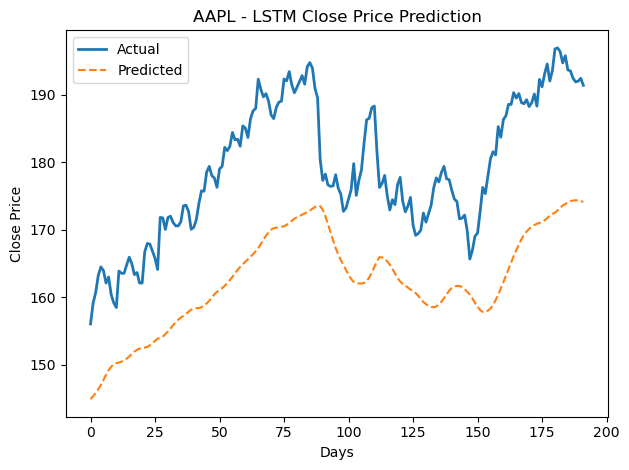

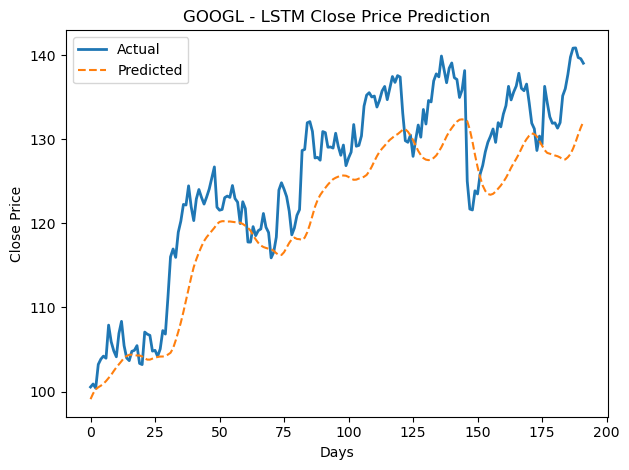

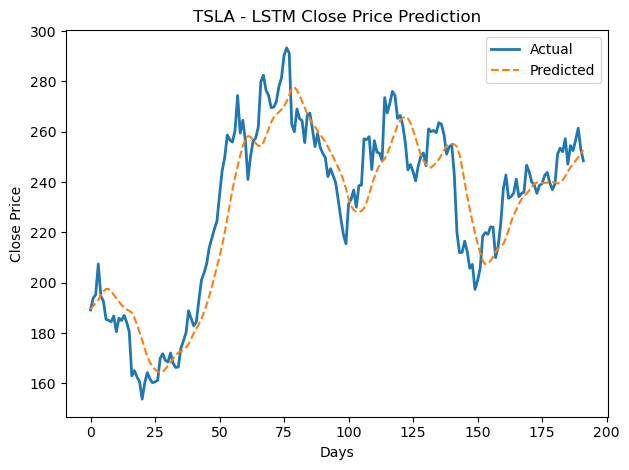

In [63]:
example_stocks = ["AAPL", "GOOGL", "TSLA"]

for stock in example_stocks:
    if stock not in results_lstm:
        continue

    y_pred = results_lstm[stock]['y_pred']
    y_true = results_lstm[stock]['y_true']
    scaler = results_lstm[stock]['scaler']

    dummy = np.zeros((len(y_pred), 5))
    dummy[:, 3] = y_pred
    y_pred_real = scaler.inverse_transform(dummy)[:, 3]

    dummy[:, 3] = y_true
    y_true_real = scaler.inverse_transform(dummy)[:, 3]

    plt.figure()
    plt.plot(y_true_real, label='Actual', linewidth=2)
    plt.plot(y_pred_real, label='Predicted', linestyle='--')
    plt.title(f"{stock} - LSTM Close Price Prediction")
    plt.xlabel("Days")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 995       |
|    ep_rew_mean     | -2.74e+03 |
| time/              |           |
|    fps             | 688       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 995         |
|    ep_rew_mean          | -769        |
| time/                   |             |
|    fps                  | 573         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009020776 |
|    clip_fraction        | 0.029       |
|    clip_range           | 0.2         |
|    entro

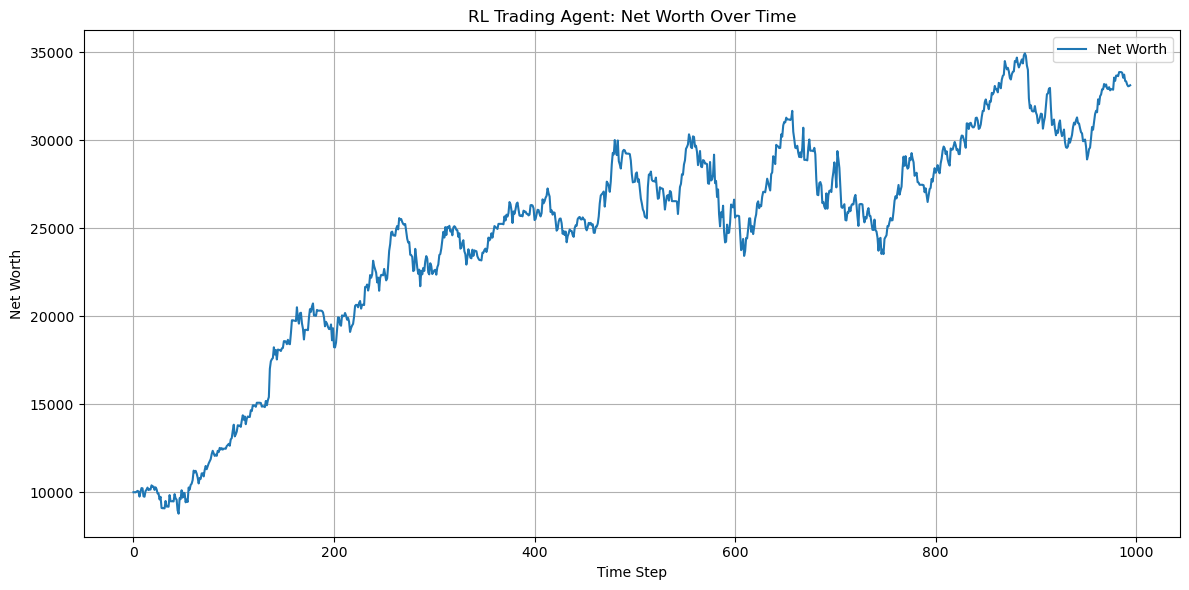

Final Net Worth: $33125.62
Profit/Loss: $23125.62


In [79]:

# --------------------------
# Reinforcement Learning Model
# --------------------------

class AdvancedStockTradingEnv(gym.Env):
    """
    A more realistic stock trading environment using historical data windows,
    transaction costs, and expanded observations.
    """
    def __init__(self, df, window_size=10, initial_balance=10000):
        super(AdvancedStockTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance

        # Action: -1 (sell), 0 (hold), 1 (buy)
        self.action_space = spaces.Discrete(3)

        # Observation: past window_size days of OHLCV (flattened)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size * 5 + 2,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.trades = []
        return self._get_observation(), {}

    def _get_observation(self):
        window = self.df.iloc[self.current_step - self.window_size:self.current_step][
            ["Open", "High", "Low", "Close", "Volume"]
        ].values.flatten()
        obs = np.append(window, [self.balance, self.shares_held])
        return obs.astype(np.float32)

    def step(self, action):
        current_price = float(self.df.iloc[self.current_step]["Close"].item())
        prev_net_worth = self.net_worth

        # Commission per trade (0.1%)
        fee = 0.001

        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            cost = shares_to_buy * current_price * (1 + fee)
            if cost <= self.balance:
                self.shares_held += shares_to_buy
                self.balance -= cost

        elif action == 2:  # Sell
            proceeds = self.shares_held * current_price * (1 - fee)
            self.balance += proceeds
            self.shares_held = 0

        self.current_step += 1
        self.net_worth = self.balance + self.shares_held * current_price
        reward = self.net_worth - prev_net_worth
        done = self.current_step >= len(self.df) - 1

        return self._get_observation(), reward, done, False, {}

# --------------------------
# Load & Prepare Stock Data
# --------------------------

import yfinance as yf
import pandas as pd

data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
data = data.dropna()[["Open", "High", "Low", "Close", "Volume"]].reset_index(drop=True)

# --------------------------
# Train PPO Agent
# --------------------------

env = AdvancedStockTradingEnv(data)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.00025, gamma=0.98)
model.learn(total_timesteps=50_000)

# --------------------------
# Evaluate Agent
# --------------------------

obs, _ = env.reset()
net_worths = []
for _ in range(env.window_size, len(data) - 1):
    action, _ = model.predict(obs)
    obs, _, done, _, _ = env.step(action)
    net_worths.append(env.net_worth)
    if done:
        break

plt.figure(figsize=(12, 6))
plt.plot(net_worths, label="Net Worth")
plt.title("RL Trading Agent: Net Worth Over Time")
plt.xlabel("Time Step")
plt.ylabel("Net Worth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Net Worth: ${env.net_worth:.2f}")
print(f"Profit/Loss: ${env.net_worth - env.initial_balance:.2f}")


Class Distribution: Positive=0.4610, Negative=0.5390
Epoch 1/25 - Avg Loss: 0.8230
Epoch 2/25 - Avg Loss: 0.7839
Epoch 3/25 - Avg Loss: 0.7765
Epoch 4/25 - Avg Loss: 0.7649
Epoch 5/25 - Avg Loss: 0.7585
Epoch 6/25 - Avg Loss: 0.7590
Epoch 7/25 - Avg Loss: 0.7501
Epoch 8/25 - Avg Loss: 0.7525
Epoch 9/25 - Avg Loss: 0.7526
Epoch 10/25 - Avg Loss: 0.7475
Epoch 11/25 - Avg Loss: 0.7478
Epoch 12/25 - Avg Loss: 0.7506
Epoch 13/25 - Avg Loss: 0.7494
Epoch 14/25 - Avg Loss: 0.7484
Epoch 15/25 - Avg Loss: 0.7486
Epoch 16/25 - Avg Loss: 0.7479
Epoch 17/25 - Avg Loss: 0.7486
Epoch 18/25 - Avg Loss: 0.7487
Epoch 19/25 - Avg Loss: 0.7473
Epoch 20/25 - Avg Loss: 0.7483
Epoch 21/25 - Avg Loss: 0.7472
Epoch 22/25 - Avg Loss: 0.7479
Epoch 23/25 - Avg Loss: 0.7478
Epoch 24/25 - Avg Loss: 0.7480
Epoch 25/25 - Avg Loss: 0.7470

--- Classification Metrics ---
Accuracy: 0.4674
Precision: 0.4664
Recall: 0.8684
F1 Score: 0.6069


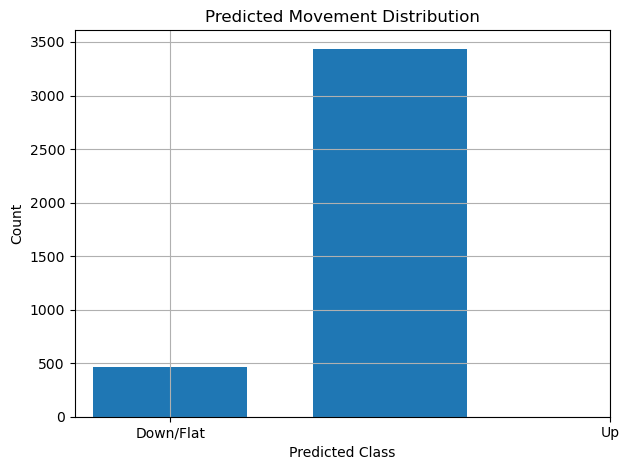

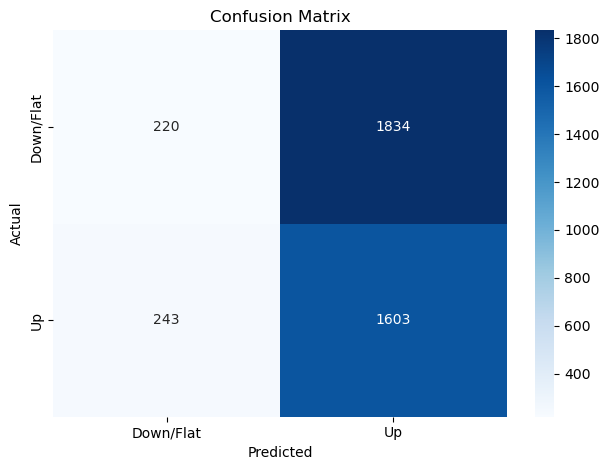

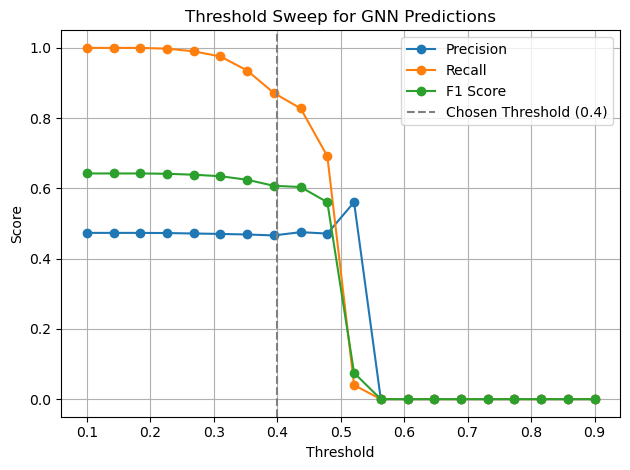

In [105]:
# --------------------------
# GNN Model
# --------------------------

def compute_features_and_targets(data, window_size=30, return_threshold=0.0025):
    features, targets, dates = [], [], data.index[window_size:-1]

    # Static edge index from full correlation matrix
    full_corr = data.pct_change().dropna().corr()
    static_edges = [(a, b) for a in range(len(full_corr.columns)) for b in range(a+1, len(full_corr.columns)) if full_corr.iloc[a, b] > 0.5]
    static_edge_index = torch.tensor(static_edges, dtype=torch.long).t().contiguous()

    for i in range(window_size, len(data) - 1):
        window = data.iloc[i - window_size:i]
        future = data.iloc[i + 1]
        returns = window.pct_change().dropna()

        mean_returns = returns.mean().values
        std_returns = returns.std().values
        skew_returns = skew(returns, axis=0)
        kurt_returns = kurtosis(returns, axis=0)

        feat_stack = np.stack([mean_returns, std_returns, skew_returns, kurt_returns], axis=1)
        feat = torch.tensor(feat_stack, dtype=torch.float32)
        features.append(feat)

        next_day_return = (future - data.iloc[i]) / data.iloc[i]
        binary_target = (next_day_return.values > return_threshold).astype(int)
        targets.append(torch.tensor(binary_target, dtype=torch.float32).unsqueeze(1))

    return features, targets, static_edge_index, dates

features, targets, static_edge_index, valid_dates = compute_features_and_targets(adj_close_data)
all_labels = torch.cat(targets).numpy().flatten()
pos_ratio = np.mean(all_labels)
print(f"\nClass Distribution: Positive={pos_ratio:.4f}, Negative={1 - pos_ratio:.4f}")

# --------------------------
# Define GNN Model
# --------------------------
class StockGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StockGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.4)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = torch.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# --------------------------
# Train/Test Split
# --------------------------
split_idx = int(0.8 * len(features))
train_features = features[:split_idx]
train_targets = targets[:split_idx]
test_features = features[split_idx:]
test_targets = targets[split_idx:]

# --------------------------
# Train the GNN Model
# --------------------------
input_dim, hidden_dim, output_dim = 4, 64, 1
model = StockGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
pos_weight = torch.tensor([(1 - pos_ratio) / pos_ratio], dtype=torch.float32)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model.train()
epochs = 25
for epoch in range(epochs):
    losses = []
    for i in range(len(train_features)):
        x = train_features[i]
        y = train_targets[i]
        optimizer.zero_grad()
        out = model(x, static_edge_index)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {np.mean(losses):.4f}")

# --------------------------
# Evaluate the GNN Model
# --------------------------
threshold = 0.4  # Adjusted threshold
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for i in range(len(test_features)):
        x, y = test_features[i], test_targets[i]
        out = torch.sigmoid(model(x, static_edge_index))
        pred = (out > threshold).int().numpy().flatten()
        truth = y.numpy().flatten()
        preds.extend(pred)
        actuals.extend(truth)

accuracy = accuracy_score(actuals, preds)
precision = precision_score(actuals, preds, zero_division=0)
recall = recall_score(actuals, preds, zero_division=0)
f1 = f1_score(actuals, preds, zero_division=0)

print("\n--- Classification Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# --------------------------
# Visualize Prediction Distribution
# --------------------------
plt.figure()
plt.hist(preds, bins=2, rwidth=0.7, align='left')
plt.xticks([0, 1], labels=['Down/Flat', 'Up'])
plt.title("Predicted Movement Distribution")
plt.ylabel("Count")
plt.xlabel("Predicted Class")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Visualize Confusion Matrix
# --------------------------
cm = confusion_matrix(actuals, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down/Flat', 'Up'], yticklabels=['Down/Flat', 'Up'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --------------------------
# Threshold Sweep Visualization
# --------------------------
model.eval()
thresholds = np.linspace(0.1, 0.9, 20)
precision_scores, recall_scores, f1_scores = [], [], []

with torch.no_grad():
    for thresh in thresholds:
        temp_preds = []
        for i in range(len(test_features)):
            x = test_features[i]
            out = torch.sigmoid(model(x, static_edge_index))
            pred = (out > thresh).int().numpy().flatten()
            temp_preds.extend(pred)

        # Compute scores
        p, r, f1, _ = precision_recall_fscore_support(actuals, temp_preds, average='binary', zero_division=0)
        precision_scores.append(p)
        recall_scores.append(r)
        f1_scores.append(f1)

# Plot the metrics over thresholds
plt.figure()
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.axvline(x=0.4, color='gray', linestyle='--', label='Chosen Threshold (0.4)')
plt.title('Threshold Sweep for GNN Predictions')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\JaeMG\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0 | D Loss: 0.6975, D Acc: 31.25% | G Loss: 0.6954
Epoch 500 | D Loss: 0.6863, D Acc: 52.73% | G Loss: 0.7411
Epoch 1000 | D Loss: 0.6828, D Acc: 52.93% | G Loss: 0.7443
Epoch 1500 | D Loss: 0.6822, D Acc: 52.65% | G Loss: 0.7366
Epoch 2000 | D Loss: 0.6816, D Acc: 52.75% | G Loss: 0.7319
Epoch 2500 | D Loss: 0.6811, D Acc: 53.02% | G Loss: 0.7277


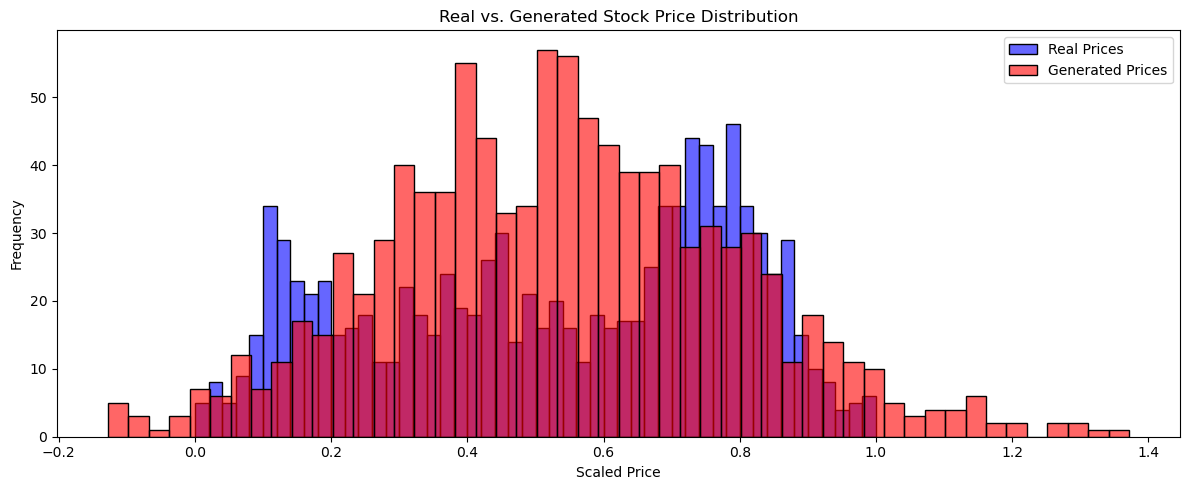

In [137]:
# --------------------------
# Generative AI Model (GAN)
# --------------------------

def build_generator(latent_dim):
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(0.2),
        Dense(1, activation='linear')
    ])
    return model

# Discriminator

def build_discriminator():
    model = Sequential([
        Dense(512, input_dim=1),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(128),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize GAN
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.trainable = False

# Combine models
gan_input = tf.keras.Input(shape=(latent_dim,))
generated_output = generator(gan_input)
gan_output = discriminator(generated_output)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

# Training Function
def train_gan(generator, discriminator, gan, data, latent_dim=100, epochs=3000, batch_size=64):
    real_data = data[:, 3].reshape(-1, 1)  # Close prices
    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.trainable = True
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_samples = real_data[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise, verbose=0)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator via GAN
        # ---------------------
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))  # Fool the discriminator
        g_loss = gan.train_on_batch(noise, misleading_labels)

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}% | G Loss: {g_loss:.4f}")

# Evaluation & Visualization
def visualize_gan(generator, real_data, latent_dim=100):
    noise = np.random.normal(0, 1, (1000, latent_dim))
    generated = generator.predict(noise, verbose=0).flatten()

    plt.figure(figsize=(12, 5))
    sns.histplot(real_data[:, 3], bins=50, color='blue', label='Real Prices', alpha=0.6)
    sns.histplot(generated, bins=50, color='red', label='Generated Prices', alpha=0.6)
    plt.title("Real vs. Generated Stock Price Distribution")
    plt.xlabel("Scaled Price")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

train_gan(generator, discriminator, gan, scaled_data, epochs=3000, batch_size=64)
visualize_gan(generator, scaled_data)


Device set to use cpu



📈 Processing AAPL...
  Headline 1: negative (0.94) → Why Apple (AAPL) Stock Is Falling Today
  Headline 2: negative (0.51) → Jefferies Warns of ‘More Earnings Downside’ for Apple. How Should You Play AAPL Stock Here?
  Headline 3: negative (0.63) → Tim Cook Says Tariffs Will Cost Apple at Least $900M in April-June Quarter
  Headline 4: negative (0.89) → Why Shares of Apple Are Sinking Today
  Headline 5: neutral (0.54) → Apple earnings takeaways: A rush to buy iPhones before tariffs, a $900 million hit, and more
  Headline 6: negative (0.94) → Apple ordered to pay Optis $502M in UK patent dispute, Reuters says
  Headline 7: negative (0.91) → Apple says tariffs will cost it a whopping $900 million this quarter
  Headline 8: neutral (0.91) → 9to5Mac Daily: May 2, 2025 – AAPL earnings, big App Store changes
  Headline 9: positive (0.62) → Stock Market Today: Dow Jones Soars 400 Points On Strong Jobs Report; Palantir Stock Jumps Ahead Of Results (Live Coverage)
  Headline 10: negative (0.

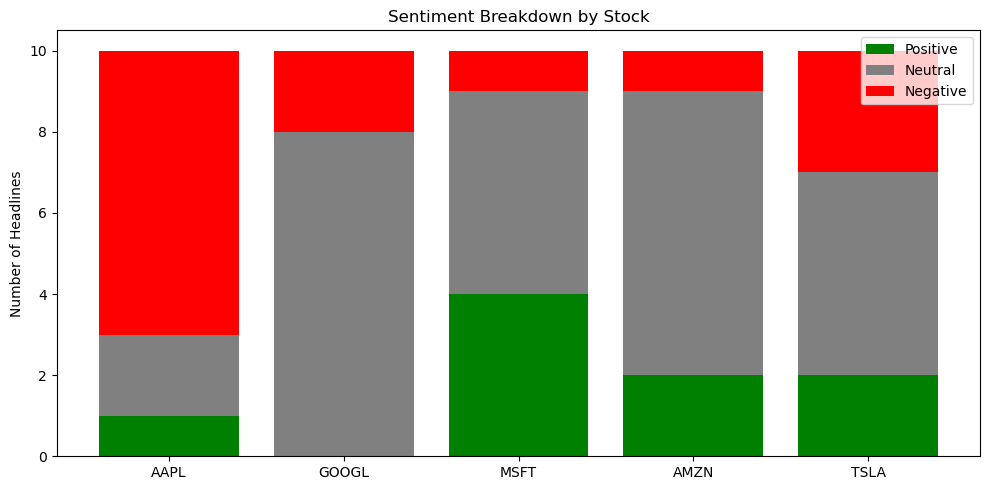


📊 Average Sentiment Scores (1=Positive, -1=Negative):
AAPL: -0.60
GOOGL: -0.20
MSFT: 0.30
AMZN: 0.10
TSLA: -0.10


In [3]:
# --------------------------
# Large Language Model (FinBERT) Sentiment Analysis
# --------------------------

# --- Setup ---
api_key = "1bdcfa74144a49678a43e3c1962b35fa"
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
sentiment_model = pipeline("text-classification", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert", framework="pt")
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# --- Storage ---
sentiment_summary = {}

# --- Loop over tickers ---
for ticker in tickers:
    print(f"\n📈 Processing {ticker}...")
    url = f"https://newsapi.org/v2/everything?q={ticker}&sortBy=publishedAt&language=en&apiKey={api_key}"
    response = requests.get(url)
    articles = response.json().get("articles", [])
    
    if not articles:
        print(f"⚠️ No news found for {ticker}.")
        continue
    
    headlines = [article["title"] for article in articles[:10]]  # Limit to 10 headlines
    results = sentiment_model(headlines)

    numeric_scores = [sentiment_mapping[r["label"].lower()] for r in results]
    avg_score = np.mean(numeric_scores)
    sentiment_summary[ticker] = {
        "headlines": list(zip(headlines, results)),
        "average_score": avg_score,
        "label_counts": Counter([r["label"] for r in results])
    }

    # Print detailed results
    for i, (hl, res) in enumerate(zip(headlines, results), 1):
        print(f"  Headline {i}: {res['label']} ({res['score']:.2f}) → {hl}")

# --- Visualization ---
plt.figure(figsize=(10, 5))
for ticker, data in sentiment_summary.items():
    label_counts = data["label_counts"]
    plt.bar(ticker, label_counts.get("positive", 0), color="green")
    plt.bar(ticker, label_counts.get("neutral", 0), bottom=label_counts.get("positive", 0), color="gray")
    plt.bar(ticker, label_counts.get("negative", 0), 
            bottom=label_counts.get("positive", 0) + label_counts.get("neutral", 0), color="red")

plt.title("Sentiment Breakdown by Stock")
plt.ylabel("Number of Headlines")
plt.legend(["Positive", "Neutral", "Negative"])
plt.tight_layout()
plt.show()

# --- Summary Scores ---
print("\n📊 Average Sentiment Scores (1=Positive, -1=Negative):")
for ticker, data in sentiment_summary.items():
    print(f"{ticker}: {data['average_score']:.2f}")

In [5]:
# Model comparison summary
comparison_data = {
    "Model": ["LSTM", "Reinforcement Learning", "GNN", "GAN", "FinBERT"],
    "Task": [
        "Predict future stock price",
        "Optimize portfolio returns",
        "Classify next-day direction",
        "Generate synthetic prices",
        "Analyze news sentiment"
    ],
    "Metric": [
        "MAE / MSE / R²",
        "Final Net Worth / P&L",
        "Accuracy / F1 Score",
        "KL Divergence",
        "Sentiment vs Price Corr."
    ],
    "Strengths": [
        "Captures temporal patterns",
        "Learns sequential decisions",
        "Models stock relationships",
        "Simulates realistic prices",
        "Handles textual news data"
    ],
    "Limitations": [
        "Needs clean time series",
        "Sensitive to reward design",
        "Hard to tune graph setup",
        "Hard to evaluate quality",
        "Sentiment ≠ price direction"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Model,Task,Metric,Strengths,Limitations
0,LSTM,Predict future stock price,MAE / MSE / R²,Captures temporal patterns,Needs clean time series
1,Reinforcement Learning,Optimize portfolio returns,Final Net Worth / P&L,Learns sequential decisions,Sensitive to reward design
2,GNN,Classify next-day direction,Accuracy / F1 Score,Models stock relationships,Hard to tune graph setup
3,GAN,Generate synthetic prices,KL Divergence,Simulates realistic prices,Hard to evaluate quality
4,FinBERT,Analyze news sentiment,Sentiment vs Price Corr.,Handles textual news data,Sentiment ≠ price direction


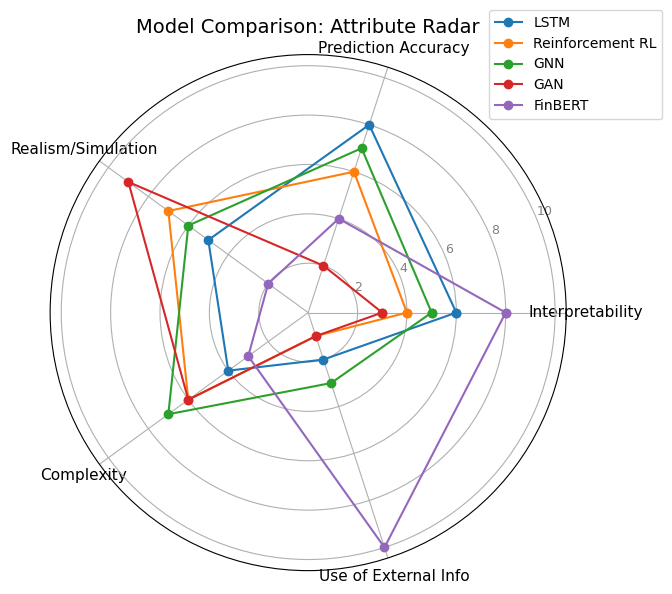

In [7]:
# Define model names and their ratings (scale 0–10)
labels = ["Interpretability", "Prediction Accuracy", "Realism/Simulation", "Complexity", "Use of External Info"]
models = {
    "LSTM":               [6, 8, 5, 4, 2],
    "Reinforcement RL":   [4, 6, 7, 6, 1],
    "GNN":                [5, 7, 6, 7, 3],
    "GAN":                [3, 2, 9, 6, 1],
    "FinBERT":            [8, 4, 2, 3, 10]
}

# Radar chart setup
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(10, 6))
for model, scores in models.items():
    values = scores + scores[:1]
    plt.polar(angles, values, label=model, marker='o')

plt.xticks(angles[:-1], labels, fontsize=11)
plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", fontsize=9)
plt.title("Model Comparison: Attribute Radar", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()